# BSCINT FFT

In [55]:
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
import scipy.interpolate
from scipy.fftpack import rfft, rfftfreq
from nxcals.api.extraction.data.builders import *

import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

In [56]:
with open('rfko_gain_dataframe.pickle', 'rb') as f:
    df_gain = pickle.load(f)

In [57]:
start = df_gain.timestamp.min() # UTC
end = df_gain.timestamp.max() # UTC

In [58]:
df_bxscint1000 = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("BXSCINT_1000/Acquisition").build().toPandas()

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [59]:
df_bxscint1000["timestamp"] = df_bxscint1000["acqStamp"]/1000000000
df_bxscint1000["timestamp"] = [datetime.fromtimestamp(x) for x in df_bxscint1000["timestamp"]]
df_bxscint1000["signal"] = [x["elements"] for x in df_bxscint1000.countArray]
df_bxscint1000.sort_values(by = ["timestamp"], inplace = True)

df_merged = pd.merge_asof(df_bxscint1000, df_gain, on="timestamp", direction='nearest')

In [60]:
df_merged.keys()

Index(['__record_timestamp__', '__record_version__', 'acqMsg', 'acqStamp',
       'acqState', 'acqTime', 'beamID', 'class', 'coincidenceDeviceName',
       'countArray', 'countCoincidenceArray', 'countNumber', 'counts',
       'countsCoincidence', 'cyclestamp', 'delay', 'delayDefault', 'device',
       'deviceDetailedStatus', 'deviceName', 'equipmentName', 'fifoFreq',
       'highVoltage', 'highVoltageDefault', 'inOutPosition',
       'moduleHardwareAcquisitionWd', 'moduleHardwareeventMonitorWD',
       'property', 'selector', 'superCycleNb', 'nxcals_entity_id', 'timestamp',
       'signal', 'gain', 'voltage', 'energy'],
      dtype='object')

In [61]:
fifoFreq = 2000
nbOfSamples = 1024
integrationDuration = nbOfSamples*(1/fifoFreq)*1000 # in ms
t2 = np.arange(0, integrationDuration, integrationDuration / nbOfSamples)# time in ms
delta_t = t2[1]-t2[0]

In [62]:
t2[-1]

511.5

Text(0, 0.5, 'Amplitude [arb.]')

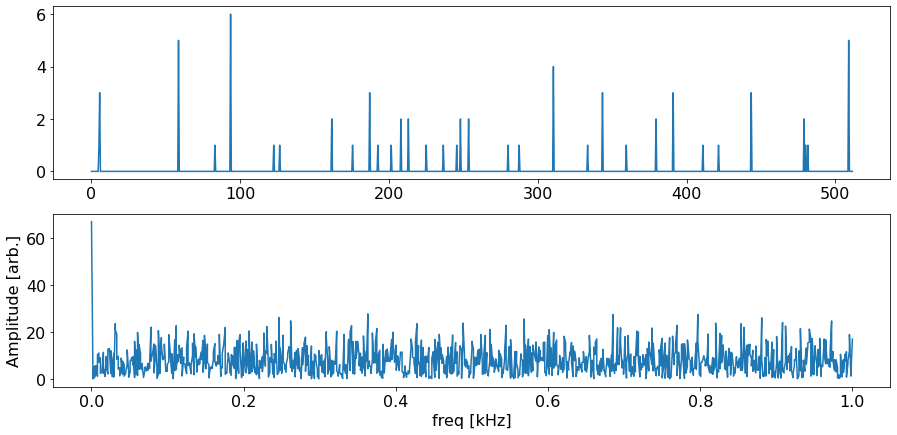

In [63]:
signal = df_merged.countArray[9]["elements"]

yf = rfft(signal)
xf = rfftfreq(len(signal), delta_t)

fig, ax = plt.subplots(2,1, figsize=(15,7))
ax[0].plot(t2, signal)
ax[1].plot(xf, np.abs(yf))
ax[1].set_xlabel("freq [kHz]")
ax[1].set_ylabel("Amplitude [arb.]")

In [64]:
df = df_merged[['signal', 'selector', 'gain']].copy()
df["intensity"] = [abs(x.sum()) for x in df.signal]
df["length"] = [len(x) for x in df.signal]
window_size = (310,980)
df["signal_windowed"] = [x[window_size[0]:window_size[1]] for x in df.signal]
df["fft"] = [ rfft(x) for x in df.signal_windowed]
df["xf"] = [ rfftfreq(len(x), delta_t) for x in df.signal_windowed]

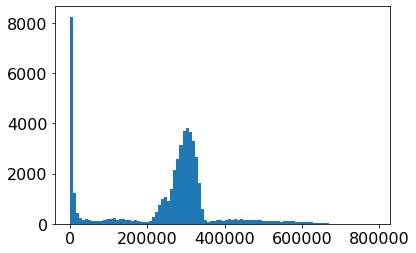

In [65]:
df = df.sort_values(by=["intensity"], ascending=False)[4:]
df.reset_index(drop=True, inplace=True)

plt.hist(df.intensity, bins = 100);

In [66]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

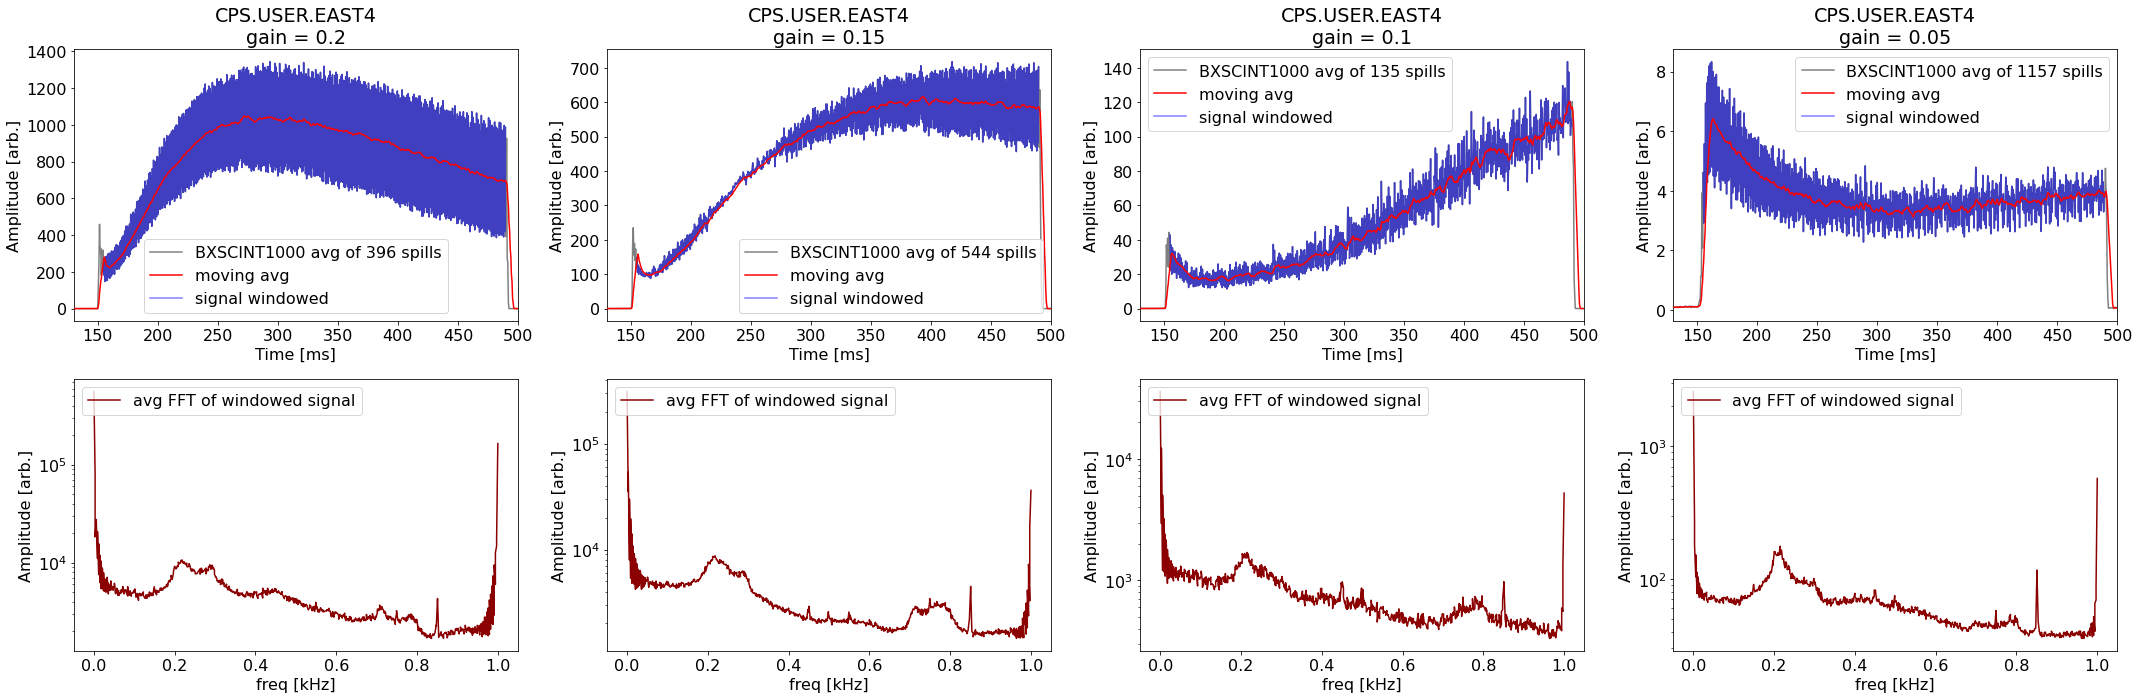

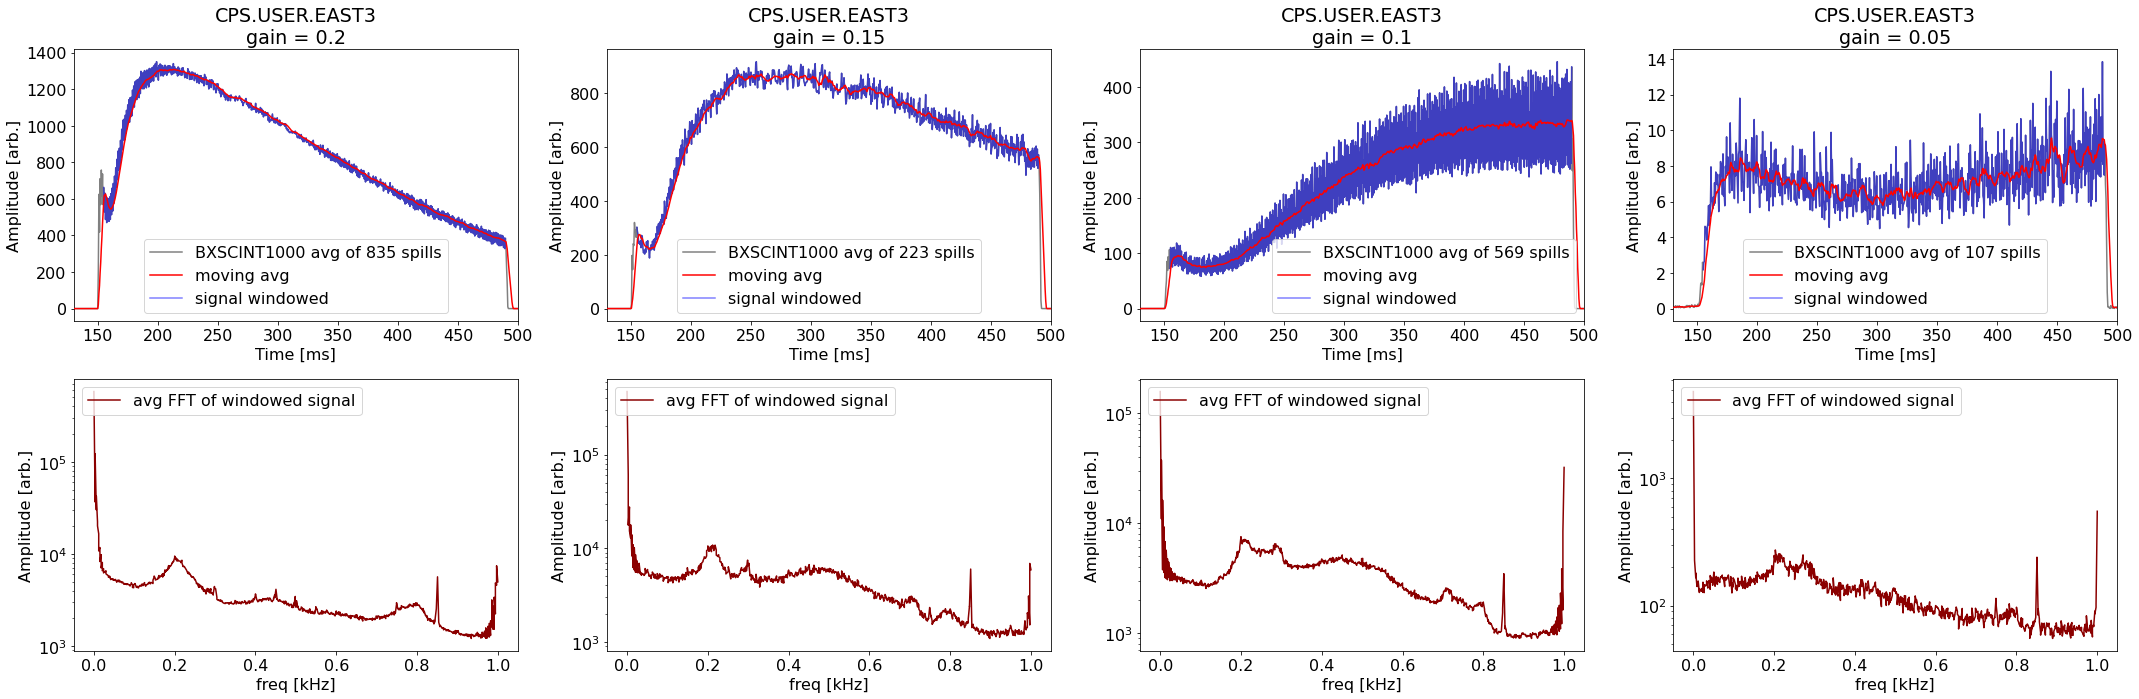

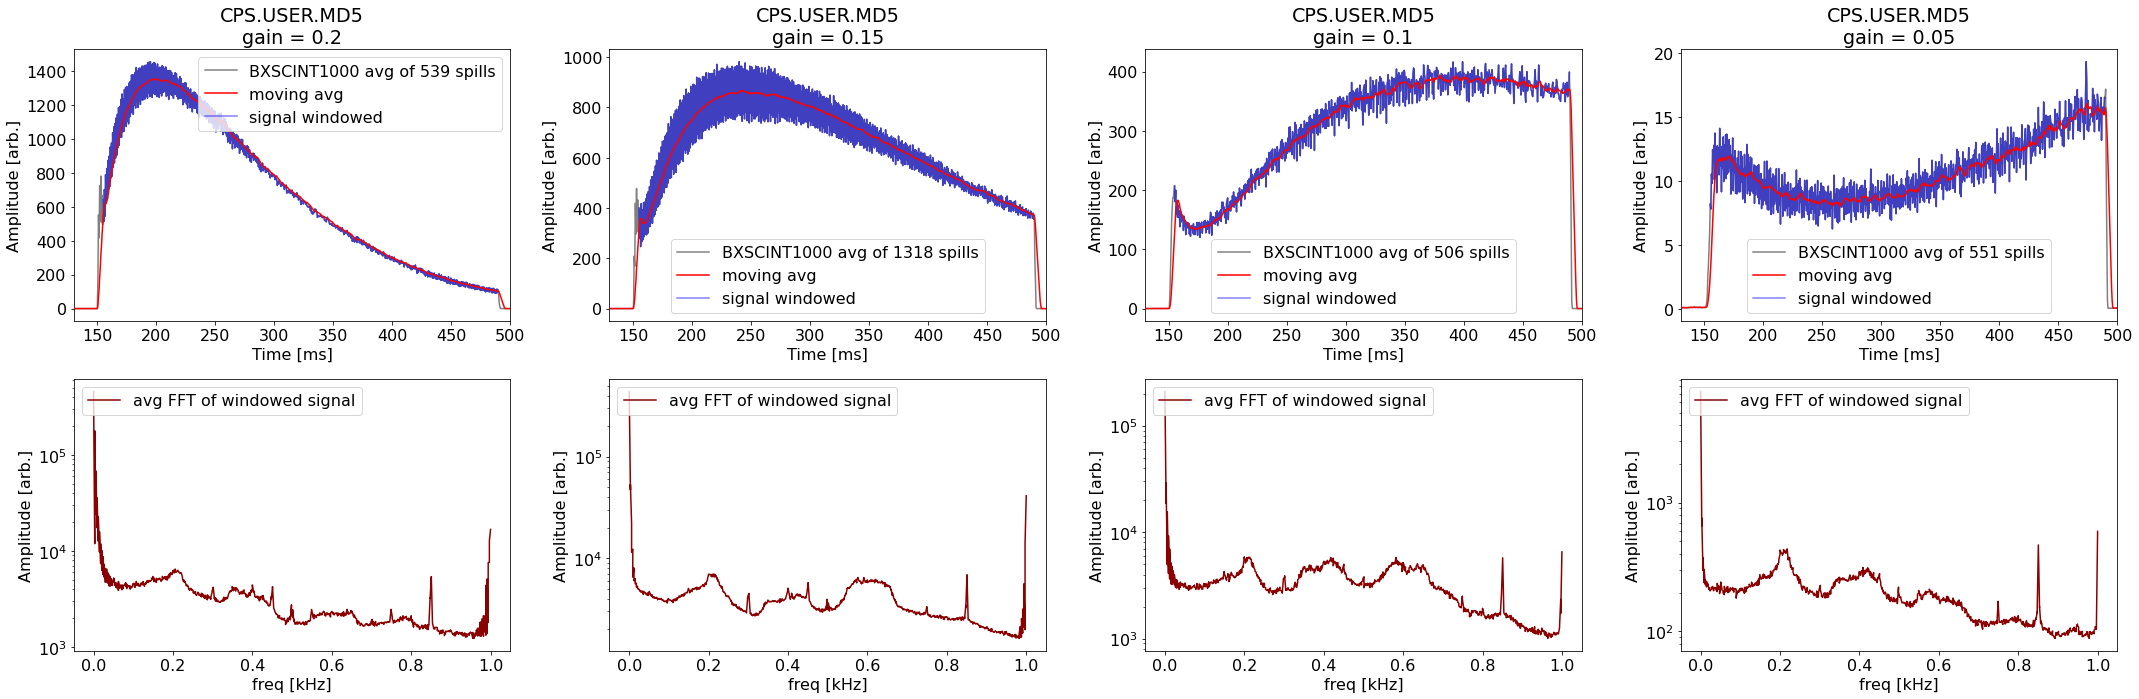

In [67]:
user_list = ["CPS.USER.EAST4", "CPS.USER.EAST3", "CPS.USER.MD5"]
gain_list = [0.2, 0.15, 0.1, 0.05]

# user_list = ["CPS.USER.EAST4",]
# gain_list = [0.2, 0.15, 0.1, 0.05]

for user in user_list:
    
    ax_i = 0
    fig, ax = plt.subplots(2,4, figsize=(30,10), tight_layout=True)
    
    for gain in gain_list:

        dfm = df.where(df.intensity > 1000)
        dfm = dfm.where(dfm.selector == user)
        dfm = dfm.where(dfm.gain == gain)
        dfm.dropna(inplace=True)
        dfm.reset_index(drop=True, inplace =True)

#         for i in range(len(dfm.signal)):
#             ax[0,ax_i].plot(t2, dfm.signal[i], c="gray", alpha=0.01,zorder=0)
        
        signal_mean = dfm.signal.sum()/len(dfm.signal)
        ax[0,ax_i].plot(t2, signal_mean, c="gray", label=f"BXSCINT1000 avg of {len(dfm.signal)} spills", zorder=1)

        window = 10
        signal_mov_avg = moving_average(signal_mean, window)
        ax[0,ax_i].plot(t2[window-1:], signal_mov_avg, c="r", label="moving avg", zorder=11)
        

        signal_windowed_mean = dfm.signal_windowed.sum()/len(dfm.signal_windowed)
        ax[0,ax_i].plot(t2[window_size[0]:window_size[1]], signal_windowed_mean, c="blue", label="signal windowed", alpha=0.5, zorder=10)

        
        ax[0, ax_i].set_ylabel("Amplitude [arb.]")
        ax[0, ax_i].set_xlabel("Time [ms]")
        ax[0, ax_i].set_xlim(130, 500)
        
        # FFT
        yf_mean = abs(dfm.fft).sum()/len(dfm.fft)
        xf_mean = dfm.xf.sum()/len(dfm.xf)
        
        ax[1,ax_i].plot(xf_mean, yf_mean, label="avg FFT of windowed signal", c="darkred")
        
#         # Find peaks
#         sp = yf_mean/yf_mean.max()
#         peaks, _ = find_peaks(sp, prominence=4e-3, width=2)
#         ax[1,ax_i].plot(x[0][peaks], sp[peaks]*yf_mean.max(), "x", c="red")
        
        ### Labels and stuff
        ax[1,ax_i].set_xlabel("freq [kHz]")
        ax[1,ax_i].set_ylabel("Amplitude [arb.]")
        ax[1, ax_i].set_yscale("log")
        
        ax[0,ax_i].set_title(f"{user}\ngain = {gain}")
        ax[0,ax_i].legend().set_zorder(11)
        ax[1,ax_i].legend(loc="upper left").set_zorder(11)
        
        ax_i +=1
        plt.savefig("fig/spill_profile_bxscint_fft"+str(user)+".png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

# Let's look at the intensity spread

562995.0757575758
314033.41727941175
36496.21481481481
2484.0138408304497
585875.1628742515
475434.9282511211
157787.09666080843
4878.719626168225
461460.7662337662
442055.50303490134
211437.58300395258
7347.831215970962


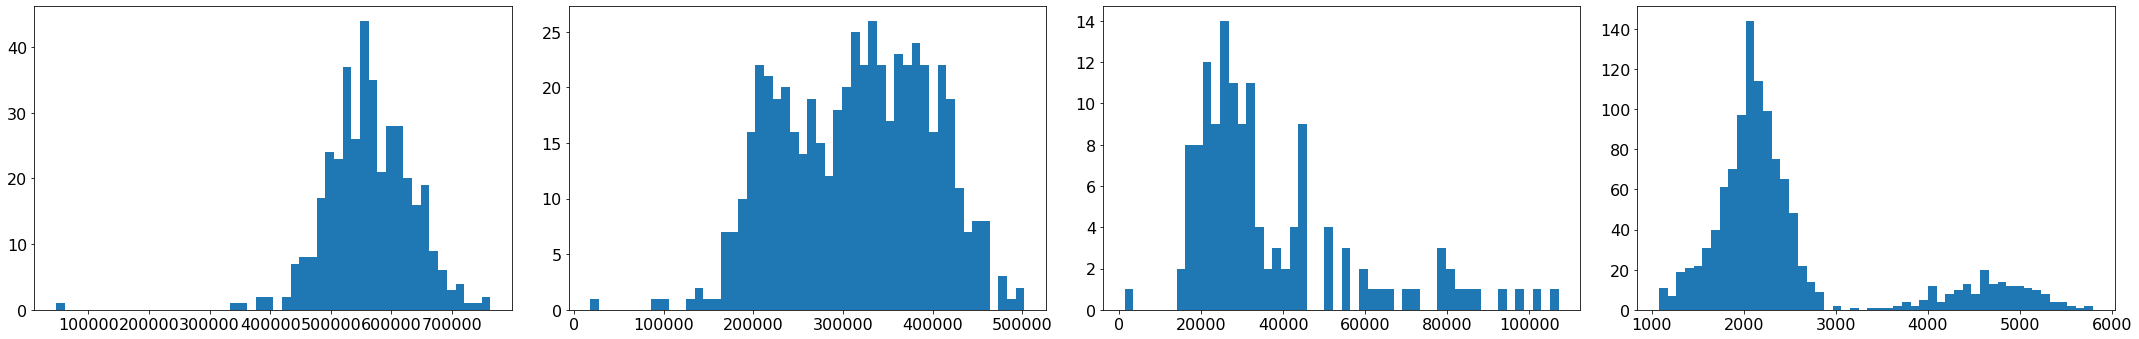

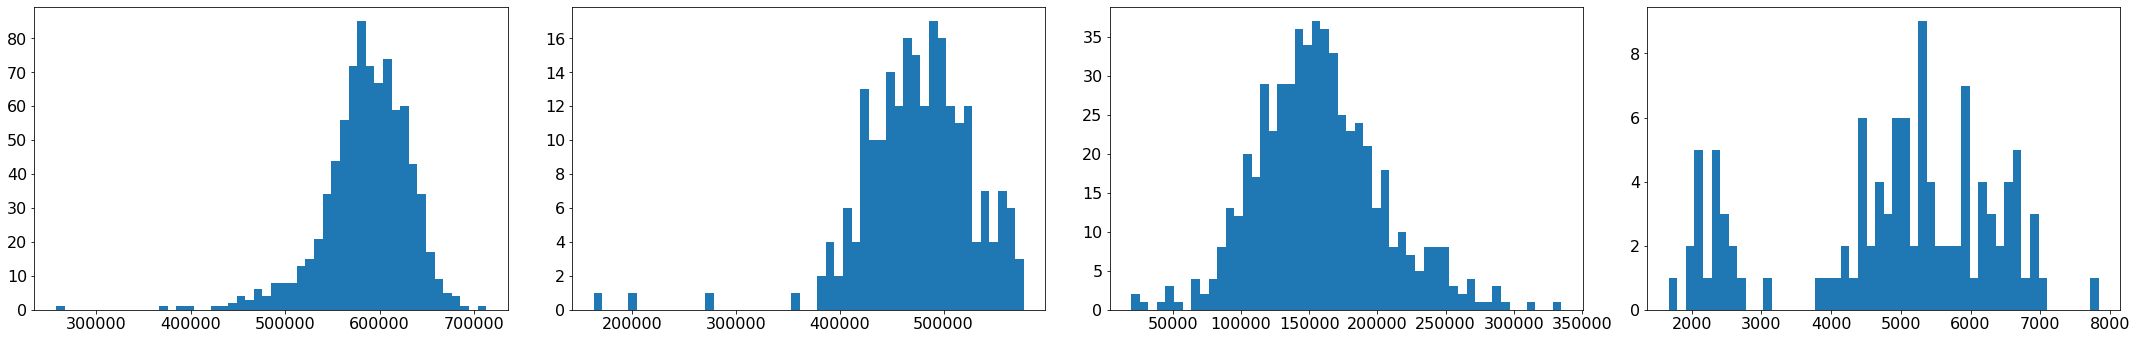

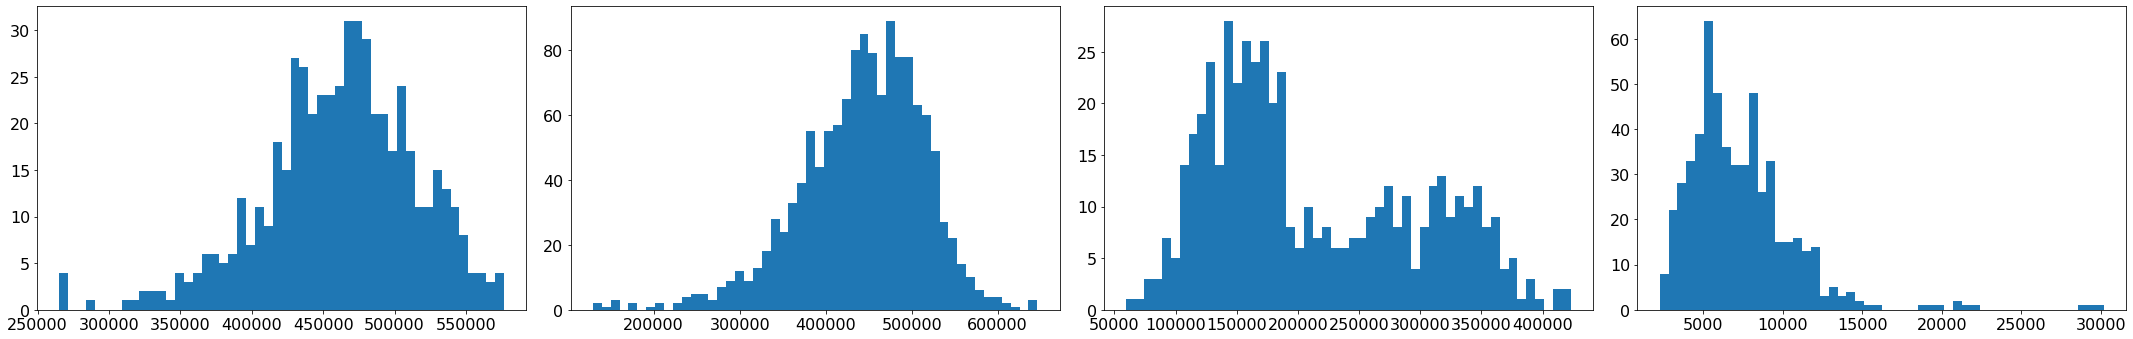

In [68]:
user_list = ["CPS.USER.EAST4", "CPS.USER.EAST3", "CPS.USER.MD5"]
gain_list = [0.2, 0.15, 0.1, 0.05]

mu_list = []
sigma_list = []
userdf_list = []
gaindf_list = []

for user in user_list:
    
    ax_i = 0
    fig, ax = plt.subplots(1,4, figsize=(30,5), tight_layout=True)
    
    for gain in gain_list:

        dfm = df.where(df.intensity > 1000)
        dfm = dfm.where(dfm.selector == user)
        dfm = dfm.where(dfm.gain == gain)
        dfm.dropna(inplace=True)
        dfm.reset_index(drop=True, inplace =True)
        
        if ( (user == "CPS.USER.EAST4") & (gain == 0.05)):
            dfm = dfm[1:]
            dfm.reset_index(drop=True, inplace =True)
            
    
        dfm["intensity_normalized"] = [x*100/dfm.intensity.mean() for x in dfm["intensity"]] 
        
        ax[ax_i].hist(dfm.intensity, bins=50)
               
        mu = dfm.intensity.mean()
        sigma = dfm.intensity.std()
        
        print(mu)
        
        mu_list.append(mu)
        sigma_list.append(sigma)
        userdf_list.append(user)
        gaindf_list.append(gain)
        
        ax_i +=1
        
d = {'mu': mu_list, 'sigma': sigma_list, 'user': userdf_list, 'gain': gaindf_list}
df_intensity = pd.DataFrame(data=d)  

In [100]:
df_intensity["cv"] = 100*df_intensity.sigma/df_intensity.mu

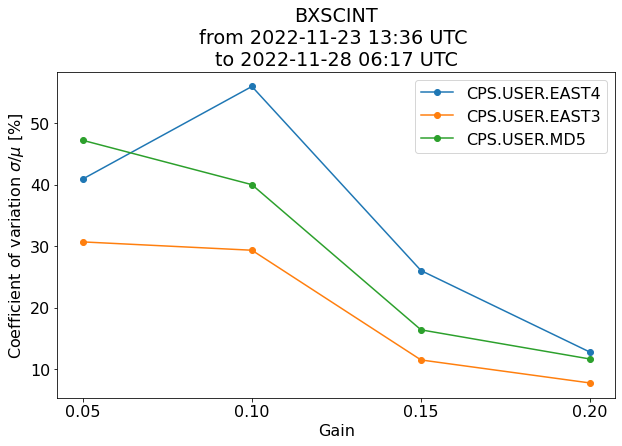

In [106]:
fig, ax = plt.subplots(figsize=(10,6))
for user in ["CPS.USER.EAST4", "CPS.USER.EAST3", "CPS.USER.MD5"]:
    df = df_intensity.where(df_intensity.user == user)
    df.dropna(inplace=True)
    df.sort_values(by="gain")
    
    ax.plot(df.gain, df.cv, marker="o", label=user)
ax.legend()
ax.set_xticks([0.05, 0.1, 0.15, 0.2]);
ax.set_xlabel("Gain")
ax.set_ylabel("Coefficient of variation $\sigma/\mu$ [%]")
ax.set_title(f"BXSCINT\nfrom {start.strftime('%Y-%m-%d %H:%M')} UTC \nto {end.strftime('%Y-%m-%d %H:%M')} UTC")
plt.savefig("fig/coefficient_variation_bxscint.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')